In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

raw_data = pd.read_csv('tickets.csv')
raw_data['datekey']=pd.to_datetime(raw_data['datekey'],format="%Y-%m-%d")

## Valor Monetario 

In [3]:
M_data = pd.DataFrame(raw_data.groupby(['customerid'])['extendedamount'].sum())
M_data = M_data.sort_values('extendedamount')
M_data.head()

,extendedamount
customerid,
77340000000163060,0.32
77000000175054667,0.33
77340000023117043,0.57
77340000010700461,0.69
77340000000549993,0.69


In [4]:
M_data['score'] = 1

for i in range(len(M_data)):
    if i > len(M_data) / 5 * 4:
        M_data.iloc[i, 1] = 5
    elif i > len(M_data) / 5 * 3:
        M_data.iloc[i, 1] = 4
    elif i > len(M_data) / 5 * 2:
        M_data.iloc[i, 1] = 3
    elif i > len(M_data) / 5:
        M_data.iloc[i, 1] = 2

In [5]:
M_data.score.value_counts().sort_values()

5    4178
4    4179
3    4179
2    4179
1    4179
Name: score, dtype: int64

## Frecuencia

In [6]:
F_data = raw_data[['ticketid', 'customerid']].copy().drop_duplicates()
F_data['ones'] = 1
F_data = pd.DataFrame(F_data.groupby('customerid')['ones'].sum())
F_data.ones.value_counts().sort_values()

38       1
33       1
80       1
47       1
40       1
51       1
31       1
35       1
32       2
37       2
30       3
29       6
26       6
25       6
27       7
28       8
24       9
23      11
22      18
20      18
21      20
18      25
19      28
17      33
16      45
15      56
14      92
13     116
12     141
11     193
10     265
9      336
8      418
7      599
6      869
5     1186
4     1712
3     2565
2     4369
1     7722
Name: ones, dtype: int64

__Cada grupo debería contener 4179 individuos pero como el número de clientes que han comprado una sola vez excede ente número, este grupo deberá ser mas grande para que tenga sentido, por lo que el criterio de asignación de grupos será el siguiente:__

__frecuencia 1 -> grupo 1 -> 7722 individuos  
frecuencia 2 -> grupo 2 -> 4369 individuos  
frecuencia 3+ -> grupo 3 -> 4277 individuos  
frecuencia 5+ -> grupo 4 -> 2654 individuos  
frecuencia 8+ -> grupo 5 -> 1872 individuos__

In [7]:
F_data['score'] = 5
F_data.loc[F_data.ones == 1, 'score'] = 1
F_data.loc[F_data.ones == 2, 'score'] = 2
F_data.loc[(F_data.ones == 3) | (F_data.ones == 4), 'score'] = 3
F_data.loc[(F_data.ones >= 5) & (F_data.ones <= 7), 'score'] = 4

In [8]:
F_data.score.value_counts().sort_values()

5    1872
4    2654
3    4277
2    4369
1    7722
Name: score, dtype: int64

## Recencia

In [9]:
lastDate = raw_data['datekey'].max()
R_data = raw_data.groupby('customerid').agg({'datekey': lambda x: (lastDate - x.max()).days})
R_data.datekey.value_counts().sort_values()

65     294
85     294
70     313
39     322
75     329
78     331
86     364
79     371
77     371
44     390
84     399
49     400
40     401
57     401
58     411
56     421
33     519
30     524
37     539
28     553
22     663
23     757
19     759
14     916
12    1354
7     1417
16    1422
9     1577
5     1976
0     2106
Name: datekey, dtype: int64

__El criterio de asignación de grupos será el siguiente:__

__recencia < 6 -> grupo 5 -> 4082 individuos  
6 < recencia < 13  -> grupo 4 -> 4348 individuos    
13 < recencia < 26  -> grupo 3 -> 4517 individuos  
26 < recencia < 57  -> grupo 2 -> 4069 individuos  
recencia >= 57  -> grupo 1 -> 3878 individuos__

In [10]:
R_data['score'] = 5
R_data.loc[(R_data.datekey > 6) & (R_data.datekey < 13), 'score'] = 4
R_data.loc[(R_data.datekey > 13) & (R_data.datekey < 26), 'score'] = 3
R_data.loc[(R_data.datekey > 26) & (R_data.datekey < 57), 'score'] = 2
R_data.loc[R_data.datekey >= 57, 'score'] = 1

In [11]:
R_data.score.value_counts().sort_values()

1    3878
2    4069
5    4082
4    4348
3    4517
Name: score, dtype: int64

In [12]:
RFM_scores = pd.DataFrame()
RFM_scores['R'] = R_data['score']
RFM_scores['F'] = F_data['score']
RFM_scores['M'] = M_data['score']
RFM_scores.head()

,R,F,M
customerid,,,
77000000050003334,2,3,5
77000000050010221,2,1,2
77000000050012258,4,4,5
77000000050014586,4,4,3
77000000050014974,2,4,4


## Clustering

In [13]:
from sklearn.cluster import KMeans

wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(RFM_scores)
    wcss.append(kmeans.inertia_)

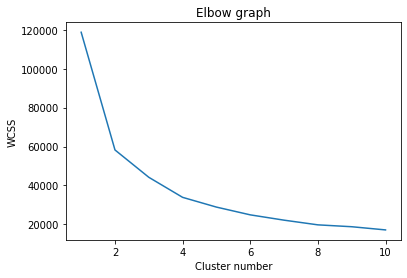

In [14]:
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

__4 parece ser un buen candidato__

In [15]:
RFM_data = pd.DataFrame()
RFM_data['R'] = R_data['datekey']
RFM_data['F'] = F_data['ones']
RFM_data['M'] = M_data['extendedamount']

In [16]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
cluster = kmeans.fit_predict(RFM_scores)

In [17]:
RFM_data['cluster'] = cluster
RFM_data.head()

,R,F,M,cluster
customerid,,,,
77000000050003334,37,3,148.96,3
77000000050010221,30,1,33.30,2
77000000050012258,9,6,138.79,1
77000000050014586,12,5,59.79,1
77000000050014974,44,6,97.09,3


Text(0.5, 0, 'Monetary')

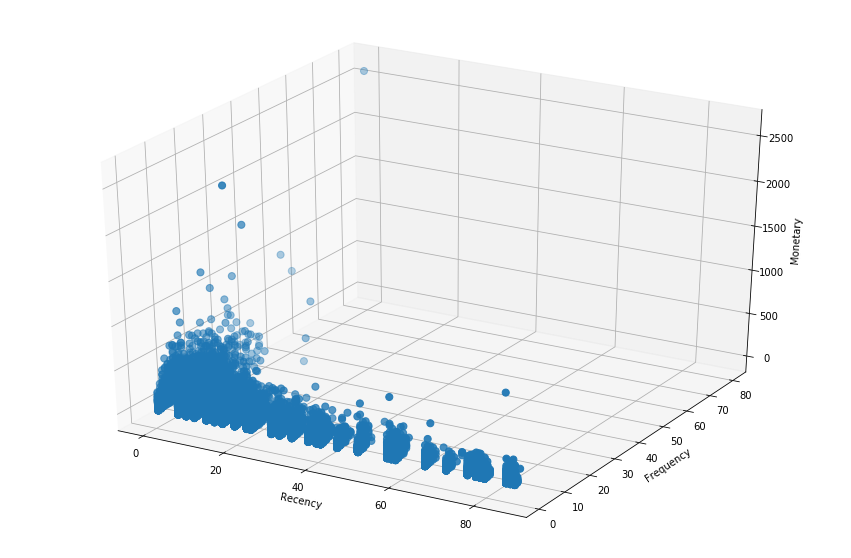

In [18]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(RFM_data.R, RFM_data.F, RFM_data.M, s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

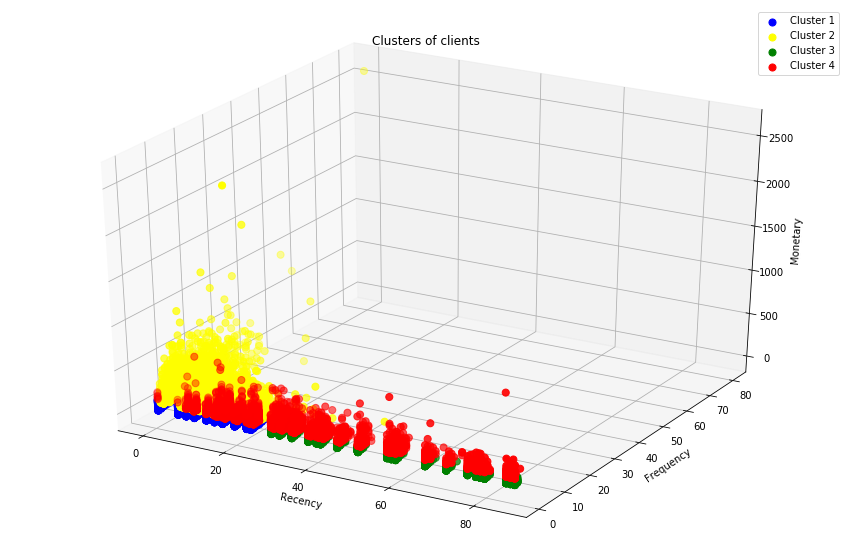

In [19]:
fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue', 'yellow', 'green', 'red']

for i in range(0,4):
    dx.scatter(RFM_data[RFM_data.cluster == i].R, 
               RFM_data[RFM_data.cluster == i].F, 
               RFM_data[RFM_data.cluster == i].M, 
               c = colors[i], 
               label = 'Cluster ' + str(i+1), 
               s=50)

dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()

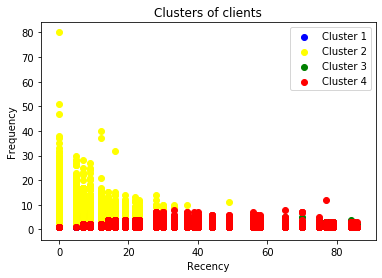

In [20]:
c1 = RFM_data[RFM_data.cluster == 0]
c2 = RFM_data[RFM_data.cluster == 1]
c3 = RFM_data[RFM_data.cluster == 2]
c4 = RFM_data[RFM_data.cluster == 3]

plt.scatter(c1.R, c1.F, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.R, c2.F, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.R, c3.F, c = 'green', label = 'Cluster 3')
plt.scatter(c4.R, c4.F, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()

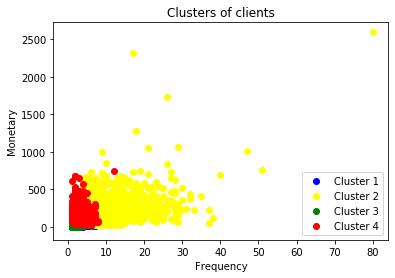

In [21]:
c1 = RFM_data[RFM_data.cluster == 0]
c2 = RFM_data[RFM_data.cluster == 1]
c3 = RFM_data[RFM_data.cluster == 2]
c4 = RFM_data[RFM_data.cluster == 3]

plt.scatter(c1.F, c1.M, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.F, c2.M, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.F, c3.M, c = 'green', label = 'Cluster 3')
plt.scatter(c4.F, c4.M, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend()

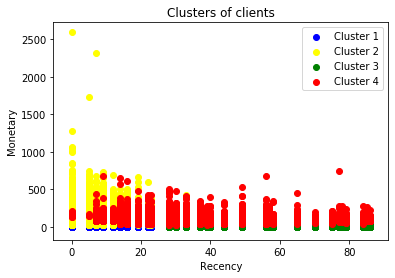

In [22]:
c1 = RFM_data[RFM_data.cluster == 0]
c2 = RFM_data[RFM_data.cluster == 1]
c3 = RFM_data[RFM_data.cluster == 2]
c4 = RFM_data[RFM_data.cluster == 3]

plt.scatter(c1.R, c1.M, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.R, c2.M, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.R, c3.M, c = 'green', label = 'Cluster 3')
plt.scatter(c4.R, c4.M, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend()

## Características de los individuos de los cluster

In [23]:
raw_data2 = pd.read_csv('customers.csv')
raw_data2 = raw_data2.drop(columns=['isocountrycode', 'registrationdate'])
raw_data2.loc[raw_data2.unregistrationdate.isnull(), 'unregistered'] = 0
raw_data2 = raw_data2.drop(columns=['unregistrationdate'])
raw_data2.loc[raw_data2.unregistered != 0, 'unregistered'] = 1
customers_data = RFM_data.merge(raw_data2, on='customerid', how='inner')
customers_data.set_index('customerid', inplace=True)
customers_data.head()

,R,F,M,cluster,regularstoreid,gender,age,zipcode,unregistered
customerid,,,,,,,,,
77000000050003334,37,3,148.96,3,ES4507,NaN,NaN,NaN,0.0
77000000050010221,30,1,33.30,2,ES0428,NaN,NaN,NaN,0.0
77000000050012258,9,6,138.79,1,ES4504,NaN,NaN,NaN,0.0
77000000050014586,12,5,59.79,1,ES0263,NaN,NaN,NaN,0.0
77000000050014974,44,6,97.09,3,ES4503,NaN,NaN,NaN,0.0


In [24]:
customers_data.regularstoreid.value_counts()

ES4503    5792
ES4504    3995
ES4507    3738
ES0428    3724
ES0263    2184
Name: regularstoreid, dtype: int64

In [25]:
customers_data.gender.value_counts()

F    9013
M    4789
2      77
1      31
0       1
Name: gender, dtype: int64

In [31]:
import numpy as np

customers_data.loc[(customers_data.age < 15.0) | (customers_data.age > 100.0), 'age'] = np.NaN
customers_data.age.max()

99.0

In [32]:
customers_data.zipcode.value_counts()

50014     1760
50007     1609
50003     1316
50017     1110
50021     1027
50015      926
50018      781
50011      705
50002      517
50012      409
50010      395
50009      359
50008      330
50013      280
50016      244
50004      220
50006      204
50019      193
50005      131
50171      114
50001       84
50022       63
50196       46
50730       46
50194       44
50059       44
50720       43
50820       43
50740       37
50830       31
          ... 
5ooo3        1
31621        1
22132        1
14900        1
50343        1
28020        1
50132        1
11540        1
43892        1
50760        1
00000        1
29620        1
50108        1
22770        1
50325        1
18600        1
5014         1
22005        1
22280        1
28017        1
50040        1
49511        1
44003        1
08022        1
28923        1
509014       1
38770        1
08221        1
50782        1
28012        1
Name: zipcode, Length: 262, dtype: int64

In [33]:
customers_data.unregistered.value_counts()

0.0    19311
1.0      122
Name: unregistered, dtype: int64

In [34]:
customers_data = customers_data.dropna()

### Genero

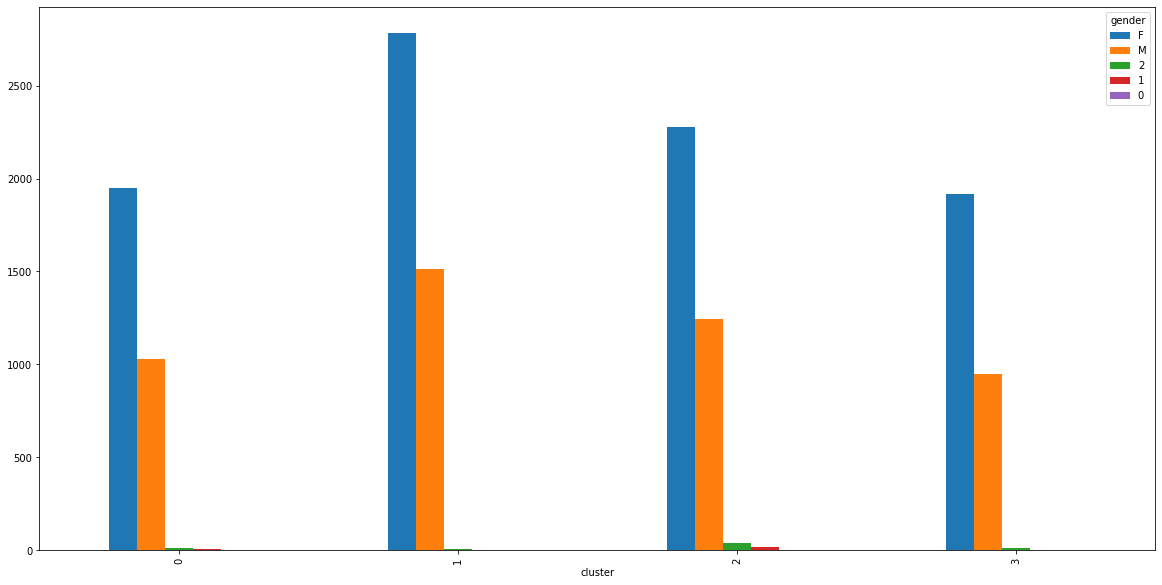

In [68]:
import seaborn as sns

plt.rcParams['figure.figsize'] =[20, 10]

customers_data.groupby(['cluster','gender'])['gender'].count().unstack().reset_index()\
.plot.bar(x = 'cluster', y = customers_data.gender.unique())

### Edad

In [63]:
age = np.unique(customers_data['age'])

def map_age(age):
    if ((age > 0) & (age <= 17)):
        return 0
    elif ((age > 18) & (age <= 27)):
        return 1
    elif ((age > 28) & (age <= 37)):
        return 2
    elif ((age > 38) & (age <= 47)):
        return 3
    elif ((age > 48) & (age <= 57)):
        return 4
    elif ((age > 58) & (age <= 67)):
        return 5
    elif ((age > 68) & (age <= 77)):
        return 6
    elif ((age > 78) & (age <= 87)):
        return 7
    elif ((age > 88) & (age <= 97)):
        return 8
    else:
        return 9
    
customers_data['age_range'] = customers_data['age'].apply(map_age)

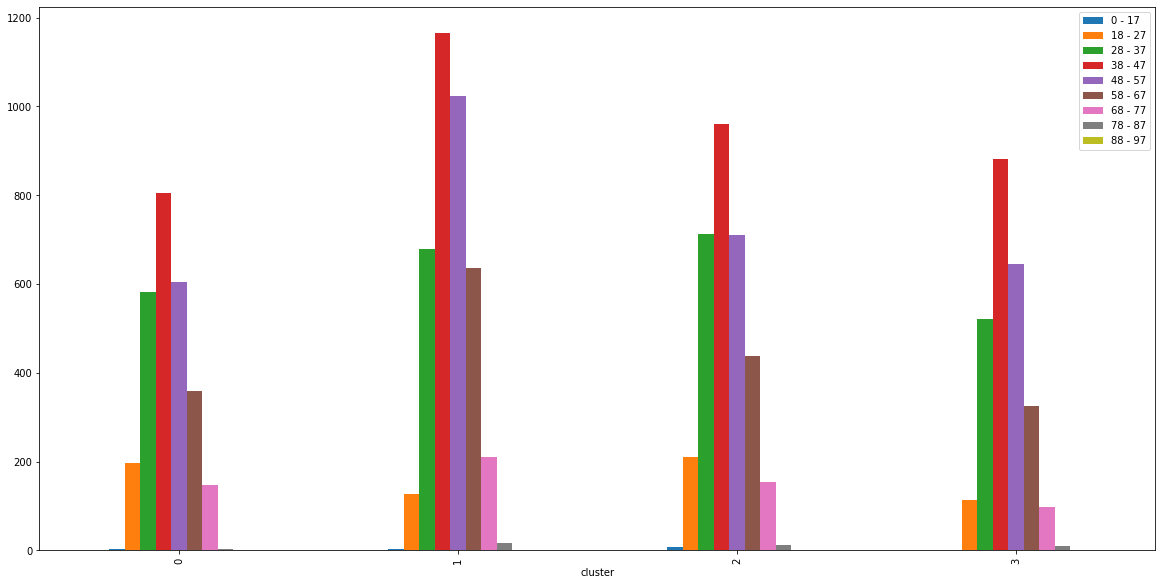

In [64]:
ax = customers_data.groupby(['cluster','age_range'])['age_range'].count().unstack().reset_index()\
.plot.bar(x = 'cluster', y = [0,1,2,3,4,5,6,7,8])

ax.legend(["0 - 17", "18 - 27","28 - 37","38 - 47","48 - 57","58 - 67","68 - 77","78 - 87","88 - 97"]);

In [154]:
print('Media de edad C1:')
customers_data.drop(customers_data[customers_data.cluster != 0].index)['age'].mean()

Media de edad C1:


46.00966344551816

In [155]:
print('Media de edad C2:')
customers_data.drop(customers_data[customers_data.cluster != 1].index)['age'].mean()

Media de edad C2:


48.25145112607383

In [156]:
print('Media de edad C3:')
customers_data.drop(customers_data[customers_data.cluster != 2].index)['age'].mean()

Media de edad C3:


45.83039955294775

In [157]:
print('Media de edad C4:')
customers_data.drop(customers_data[customers_data.cluster != 3].index)['age'].mean()

Media de edad C4:


46.41707147814018

### Tienda habitual

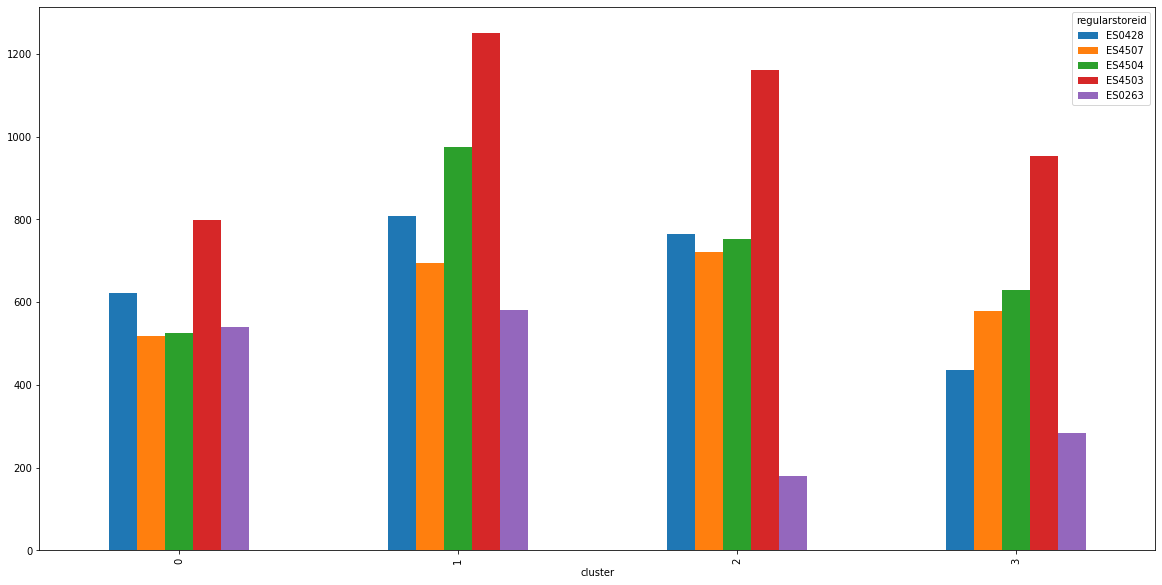

In [65]:
customers_data.groupby(['cluster','regularstoreid'])['regularstoreid'].count().unstack().reset_index()\
.plot.bar(x = 'cluster', y = customers_data.regularstoreid.unique())

### Código postal

In [147]:
zips = customers_data.groupby(['cluster','zipcode'])['zipcode'].count().unstack().reset_index()
zips = zips[zips.columns[zips.sum() > 300]]
zips.head()

zipcode,50002,50003,50007,50008,50009,50010,50011,50012,50014,50015,50017,50018,50021
0,137.0,223.0,303.0,71.0,69.0,92.0,178.0,91.0,492.0,203.0,251.0,183.0,151.0
1,124.0,539.0,479.0,71.0,87.0,102.0,221.0,107.0,689.0,257.0,386.0,206.0,484.0
2,149.0,321.0,452.0,106.0,113.0,122.0,193.0,115.0,293.0,244.0,301.0,205.0,201.0
3,107.0,233.0,374.0,81.0,90.0,78.0,113.0,96.0,286.0,220.0,171.0,184.0,190.0


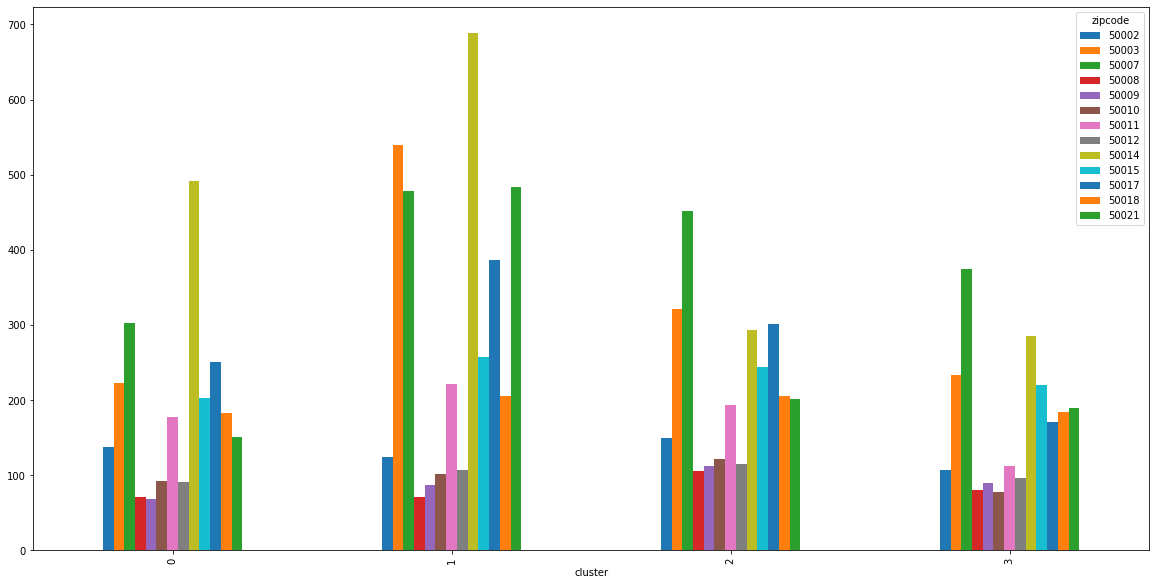

In [148]:
zips = customers_data.groupby(['cluster','zipcode'])['zipcode'].count().unstack().reset_index()\
.plot.bar(x = 'cluster', y = list(zips.columns))

### Número de clientes desregistrados

In [150]:
print('Clientes desregistrados C1:')
customers_data.drop(customers_data[customers_data.cluster != 0].index)['unregistered'].sum()

Clientes desregistrados C1:


22.0

In [151]:
print('Clientes desregistrados C2:')
customers_data.drop(customers_data[customers_data.cluster != 1].index)['unregistered'].sum()

Clientes desregistrados C2:


12.0

In [152]:
print('Clientes desregistrados C3:')
customers_data.drop(customers_data[customers_data.cluster != 2].index)['unregistered'].sum()

Clientes desregistrados C3:


68.0

In [153]:
print('Clientes desregistrados C3:')
customers_data.drop(customers_data[customers_data.cluster != 3].index)['unregistered'].sum()

Clientes desregistrados C3:


17.0

### Recencia media

In [158]:
print('Dias transcurridos en promedio desde la última compra C1:')
customers_data.drop(customers_data[customers_data.cluster != 0].index)['R'].mean()

Dias transcurridos en promedio desde la última compra C1:


11.569810063312229

In [159]:
print('Dias transcurridos en promedio desde la última compra C2:')
customers_data.drop(customers_data[customers_data.cluster != 1].index)['R'].mean()

Dias transcurridos en promedio desde la última compra C2:


6.677733921523102

In [160]:
print('Dias transcurridos en promedio desde la última compra C3:')
customers_data.drop(customers_data[customers_data.cluster != 2].index)['R'].mean()

Dias transcurridos en promedio desde la última compra C3:


60.70215143894943

In [161]:
print('Dias transcurridos en promedio desde la última compra C4:')
customers_data.drop(customers_data[customers_data.cluster != 3].index)['R'].mean()

Dias transcurridos en promedio desde la última compra C4:


31.56002775850104

### Frecuencia media

In [162]:
print('Frecuencia media de compra durante la totalidad del periodo estudiado C1:')
customers_data.drop(customers_data[customers_data.cluster != 0].index)['F'].mean()

Frecuencia media de compra durante la totalidad del periodo estudiado C1:


1.6387870709763412

In [163]:
print('Frecuencia media de compra durante la totalidad del periodo estudiado C2:')
customers_data.drop(customers_data[customers_data.cluster != 1].index)['F'].mean()

Frecuencia media de compra durante la totalidad del periodo estudiado C2:


6.9484560018574415

In [164]:
print('Frecuencia media de compra durante la totalidad del periodo estudiado C3:')
customers_data.drop(customers_data[customers_data.cluster != 2].index)['F'].mean()

Frecuencia media de compra durante la totalidad del periodo estudiado C3:


1.2696283878178263

In [165]:
print('Frecuencia media de compra durante la totalidad del periodo estudiado C4:')
customers_data.drop(customers_data[customers_data.cluster != 3].index)['F'].mean()

Frecuencia media de compra durante la totalidad del periodo estudiado C4:


2.539555863983345

### Gasto total medio

In [166]:
print('Media del gasto total de los clientes durante todo el periodo estudiado C1:')
customers_data.drop(customers_data[customers_data.cluster != 0].index)['M'].mean()

Media del gasto total de los clientes durante todo el periodo estudiado C1:


30.87083305564812

In [167]:
print('Media del gasto total de los clientes durante todo el periodo estudiado C2:')
customers_data.drop(customers_data[customers_data.cluster != 1].index)['M'].mean()

Media del gasto total de los clientes durante todo el periodo estudiado C2:


160.8565869514747

In [168]:
print('Media del gasto total de los clientes durante todo el periodo estudiado C3:')
customers_data.drop(customers_data[customers_data.cluster != 2].index)['M'].mean()

Media del gasto total de los clientes durante todo el periodo estudiado C3:


29.1003548477228

In [169]:
print('Media del gasto total de los clientes durante todo el periodo estudiado C4:')
customers_data.drop(customers_data[customers_data.cluster != 3].index)['M'].mean()

Media del gasto total de los clientes durante todo el periodo estudiado C4:


109.95072172102695